## Setup

In [65]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
import PIL
import matplotlib.image as mpimg
import shutil
from pathlib import Path
import time
from ast import literal_eval
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(8)

dataset_dir = Path('c:/Users/flori/download')

## Extract tags per specimen


In [66]:
def count_tags(dataset, subset=None, exclude_tags = ['', 'jpg', 'bmnhe', 'bmnh']):
    all_tags, file_tag_count = [], []
    ## Loop over each filename
    for i, filename in enumerate(list(dataset.filename)):
        ## Temporarly subset the dataset
        if subset != None and i > subset: break
        ## Check if the filename exists
        if isinstance(filename, str):
            tags = []
            ## Loop over each tag in the filename
            for j, tag in enumerate(re.split(r'\_| |\&|-|\.|\(|\)|\#|\,|\:', filename)): ## split on different seperators
                ## The first tag is the id of the specimen
                if j == 0: _id = int(tag)
                ## Check if the other tags aren't numbers, or in the exclude_tags var
                if tag.isnumeric() == False and tag.lower() not in exclude_tags:
                    tag = re.sub(r'[0-9]+', '#', tag).lower() ## replace all numbers in a tag with a hashtag and make all text lower
                    tags.append(tag)
        
        all_tags.append(tags)
        file_tag_count.append(len(tags))

    dataset['tags'] = all_tags
    dataset['file_tag_count'] = file_tag_count

    ## Calculate amount of files and make a list with all the tags
    id_cols = dataset.groupby('id').agg({'id': 'size', 'tags': 'sum'}).rename(columns={'id': 'id_file_count', "tags": "id_tags"})
    ## Length of the tags list
    id_cols['id_tags_count'] = id_cols['id_tags'].str.len()
    dataset = pd.merge(dataset, id_cols, on='id')

    return dataset

ds_tagged_path = Path('datasets/dataset_tagged.csv')
# dataset = pd.read_csv('datasets/dataset.csv', sep=',', encoding='ISO-8859-1', usecols=['id', 'file_description', 'filename', 'order'])
# dataset = dataset.drop_duplicates('filename')
# count_tags(dataset).to_csv(ds_tagged_path)

dataset_tagged = pd.read_csv(ds_tagged_path, index_col=0)
dataset_tagged.tags = dataset_tagged.tags.apply(literal_eval)
dataset_tagged.id_tags = dataset_tagged.id_tags.apply(literal_eval)
print(len(dataset_tagged), sum(dataset_tagged.drop_duplicates('id').id_file_count))
dataset_tagged.head(10)

496508 496508


,id,file_description,filename,order,tags,file_tag_count,id_file_count,id_tags,id_tags_count
0,6585403,BMNHE_700566_label_34588,6585403_BMNHE_700566_label_34588.jpg,diptera,[label],1,2,[label],1
1,6585403,BMNHE_700566_34588,6585403_BMNHE_700566_34588.jpg,diptera,[],0,2,[label],1
2,6585405,BMNHE_700568_label_34590,6585405_BMNHE_700568_label_34590.jpg,diptera,[label],1,2,[label],1
3,6585405,BMNHE_700568_34590,6585405_BMNHE_700568_34590.jpg,diptera,[],0,2,[label],1
4,6589069,BMNHE_700441_label_38337,6589069_BMNHE_700441_label_38337.jpg,diptera,[label],1,2,[label],1
5,6589069,BMNHE_700441_38337,6589069_BMNHE_700441_38337.jpg,diptera,[],0,2,[label],1
6,6589037,BMNHE_700447_38305,6589037_BMNHE_700447_38305.jpg,diptera,[],0,2,[label],1
7,6589037,BMNHE_700447_label_38305,6589037_BMNHE_700447_label_38305.jpg,diptera,[label],1,2,[label],1
8,6589070,BMNHE_700446_label_38338,6589070_BMNHE_700446_label_38338.jpg,diptera,[label],1,2,[label],1
9,6589070,BMNHE_700446_38338,6589070_BMNHE_700446_38338.jpg,diptera,[],0,2,[label],1


In [67]:
def label_mislabelled_manual(label):
    """Label all the items in the mislabeld directory and export this to manual_label.csv"""
    mislabeled = pd.Series(os.listdir(Path(dataset_dir, 'mislabeled_label')), name='filename')
    labeled = pd.merge(mislabeled, dataset_tagged, on='filename')
    labeled['labels'] = str(label) 
    labeled['label_iter'] = 0
    return labeled

# cols = ['filename','order','id','file_description','tags','file_tag_count','id_file_count','id_tags','id_tags_count','labels','label_iter']
# label_mislabelled = label_mislabelled_manual(['label'])[cols]
# with open('datasets/manual_label copy.csv', 'ab') as f:
#     label_mislabelled.to_csv(f, header=False)

In [68]:
def label_dataset(original, labeled_in, label_iter):
    if label_iter == 0:
        labeled = pd.read_csv(Path('datasets/manual_label copy.csv'), index_col=0)
        labeled = labeled.drop_duplicates(subset=['file_description'])
        original = original[~original.filename.isin(labeled.filename)]
    
    if label_iter == 1:
        mask = (original.id_file_count == 2) & (original.id_tags_count == 1) 
        mask = mask & original.id_tags.apply(lambda x: (any(item in x for item in ['label'])))
        original, labeled = original[~mask], original[mask]
        labeled['labels'] = labeled['file_tag_count'].apply(lambda x: ['label'] if x == 1 else ['label', 'specimen'])
        labeled['label_iter'] = int(label_iter)
        labeled = labeled_in.append(labeled, ignore_index=True)
    
    if label_iter == 2:
        mask = original.tags.apply(lambda x: 
            (any(item in x for item in ['specimen', 'dorsal', 'lateral', 'head', 'frontal', 'face', 'left', 'right'])) and 
            (not any(item in x for item in ['labels', 'label', 'alice', 'photographer'])))
        original, labeled = original[~mask], original[mask]
        labeled['labels'] = [['specimen']] * len(labeled)
        labeled['label_iter'] = int(label_iter)
        labeled = labeled_in.append(labeled, ignore_index=True)
    
    if label_iter == 3:
        mask = (original["id_file_count"] == 1)
        mask = mask & original.tags.apply(lambda x: (not any(item in x for item in ['labels', 'label'])))
        original, labeled = original[~mask], original[mask]
        labeled['labels'] = [['label', 'specimen']] * len(labeled)
        labeled['label_iter'] = int(label_iter)
        labeled = labeled_in.append(labeled, ignore_index=True)

    if label_iter == 4:
        mask = original.tags.apply(lambda x: 
            (any(item in x for item in ['labels', 'label'])) and
            (not any(item in x for item in ['and', 'with', 'dorsal', 'ventral'])))
        original, labeled = original[~mask], original[mask]
        labeled['labels'] = [['label']] * len(labeled)
        labeled['label_iter'] = int(label_iter)
        labeled = labeled_in.append(labeled, ignore_index=True)

    if label_iter == 5:
        mask = (original.id_file_count == 2) & (original.order == 'hemiptera')
        mask = mask & original.id_tags.apply(lambda x: (any(item in x for item in ['additional'])))
        original, labeled = original[~mask], original[mask]
        labeled['labels'] = labeled['tags'].apply(lambda x: ['label'] if x == ['additional'] else ['label', 'specimen'])
        labeled['label_iter'] = int(label_iter)
        labeled = labeled_in.append(labeled, ignore_index=True)

    return original, labeled

original = dataset_tagged.copy(deep=True)
labeled = pd.DataFrame(columns=original.columns)

output_df = pd.DataFrame(columns=['batch','total','orignal','labeled'])
print('batch\ttotal\torignal\tlabeled')
print(f"\t{original.shape[0] + labeled.shape[0]}\t{original.shape[0]}\t{labeled.shape[0]}")
for label_iter in range(6):
    original, labeled = label_dataset(original, labeled, label_iter)
    print(f"{label_iter}\t{original.shape[0] + labeled.shape[0]}\t{original.shape[0]}\t{labeled.shape[0]}")

labeled['filename_folder'] = labeled.labels.astype(str).replace([str(['specimen']), str(['label','specimen']), str(['label'])], ['specimen/', 'both/', 'label/'])
labeled.filename_folder = labeled.filename_folder + labeled.filename

print('Checks:')
print(all(labeled.labels.astype(str).unique() == ["['label', 'specimen']", "['specimen']", "['label']"]))

labeled

batch	total	orignal	labeled
	496508	496508	0
0	496508	494438	2070
1	496508	410206	86302
2	496508	368923	127585
3	496508	231996	264512
4	496508	226754	269754
5	496508	212674	283834
Checks:
True


,filename,order,id,file_description,tags,file_tag_count,id_file_count,id_tags,id_tags_count,labels,label_iter,filename_folder
0,8244638_011251486_lateral.jpg,ephemeroptera,8244638,011251486_lateral,['lateral'],1,7,"['alice', 'dorsal', 'lateral', 'additional', '...",7,"['label', 'specimen']",0,both/8244638_011251486_lateral.jpg
1,8242567_011246746_lateral.jpg,ephemeroptera,8242567,011246746_lateral,['lateral'],1,7,"['alice', 'dorsal', 'additional', 'additional'...",7,"['label', 'specimen']",0,both/8242567_011246746_lateral.jpg
2,8243797_011252129_lateral.jpg,ephemeroptera,8243797,011252129_lateral,['lateral'],1,7,"['alice', 'dorsal', 'additional', 'lateral', '...",7,"['label', 'specimen']",0,both/8243797_011252129_lateral.jpg
3,8243670_011253512_lateral.jpg,ephemeroptera,8243670,011253512_lateral,['lateral'],1,7,"['alice', 'dorsal', 'additional', 'lateral', '...",7,"['label', 'specimen']",0,both/8243670_011253512_lateral.jpg
4,8242566_011249199_lateral.jpg,ephemeroptera,8242566,011249199_lateral,['lateral'],1,7,"['alice', 'dorsal', 'additional', 'additional'...",7,"['label', 'specimen']",0,both/8242566_011249199_lateral.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
283829,9016939_013525196_additional.jpg,hemiptera,9016939,013525196_additional,[additional],1,2,"[type, additional]",2,[label],5,label/9016939_013525196_additional.jpg
283830,9013219_013552505_117311_1098809_157873_Type.jpg,hemiptera,9013219,013552505_117311_1098809_157873_Type,[type],1,2,"[type, additional]",2,"[label, specimen]",5,both/9013219_013552505_117311_1098809_157873_T...
283831,9013219_013552505_additional.jpg,hemiptera,9013219,013552505_additional,[additional],1,2,"[type, additional]",2,[label],5,label/9013219_013552505_additional.jpg
283832,9012896_013552504_117311_1098809_157873_Type.jpg,hemiptera,9012896,013552504_117311_1098809_157873_Type,[type],1,2,"[type, additional]",2,"[label, specimen]",5,both/9012896_013552504_117311_1098809_157873_T...


In [69]:
## Show images
def process(filename: str=None) -> None:
    try:
        image = mpimg.imread(filename)
        plt.figure()
        plt.axis('off')
        plt.tight_layout()
        plt.title(filename)
        plt.imshow(image)
    except Exception as e:
        print(e) 

# for file in labeled[labeled.label_iter == 3].filename[:10]:
#     process(Path(dataset_dir / 'hemiptera' / file))

In [70]:
## Move images
def move_items(from_list, dir_from, dir_to):
    print('List total: ', len(from_list))
    from_list = set(from_list) - set(os.listdir(dir_to))
    print('Will move: ', len(from_list))
    a =  'y' #input(f"Do you want to move items from {dir_from} to {dir_to}? [y/n]")
    if a == "y" and os.path.exists(dir_from) and os.path.exists(dir_to):
        failed = 0
        for i, f in enumerate(from_list):
            if i % 10000 == 0: print(i)
            try: shutil.move(dir_from / f,  dir_to / f)
            except Exception as e: failed += 1
        print('failed:', failed, 'succeeded', len(from_list)-failed)
    else: print(f"Something went wrong. {os.path.exists(dir_from), os.path.exists(dir_to)}")

# from_list = os.listdir(dir_from)
# from_list = list(labeled[labeled.labels.astype(str) == "['label']"].filename)
# from_list = list(labeled[labeled.label_iter == 1].filename)
from_list = list(labeled.filename)

# dir_from = dataset_dir / 'original'
# dir_to = dataset_dir / 'subset' 
# move_items(from_list[:], dir_from, dir_to)

In [71]:
## make sure the dataset is sorted because of https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
## also check if every image is in the dataframe

dir_to = Path(dataset_dir / 'subset')
sorted_dir = pd.Series(list(os.walk(dir_to))[0][2], name='filename')
print(sorted_dir.shape)
ds_sorted = pd.merge(sorted_dir, labeled, left_on='filename', right_on='filename')
ds_sorted.shape

(281128,)


(281128, 12)

In [72]:
## Check if the images are actually readable, this may take a while
def check_image(path):
    try:
        img = PIL.Image.open(path)
        img.verify()
        img.close()
        return True
    except Exception as e:
        print(e)
        return False


# ds_sorted['check_image'] = ds_sorted.filename.apply(lambda x: check_image(dir_to / x))
# print(ds_sorted.check_image.value_counts())
# ds_sorted = ds_sorted[ds_sorted.check_image == True].drop('check_image', axis=1)

In [73]:
# Save the dataset to csv
# timestr = time.strftime("%Y%m%d-%H%M%S")
# ds_sorted.to_csv(Path('subset_logs/' + timestr + '.csv'))

In [74]:
## check if the datset is balanced
ds_family = dataset_tagged["order"].value_counts().rename('dataset')
subset_family = ds_sorted["order"].value_counts().rename('subset')
order = pd.concat([ds_family, subset_family], axis=1)

order['ds%'] = (order['dataset'] / order['dataset'].sum()) * 100
order['ss%'] = (order['subset'] / order['subset'].sum()) * 100

ds_sorted.labels = ds_sorted.labels.astype(str)
ds_balance = ds_sorted[['labels', 'order']]
ds_balance = ds_balance.pivot_table(index="order", columns="labels", aggfunc=len, fill_value=0)
ds_balance = pd.merge(order, ds_balance, left_index=True, right_index=True)
ds_balance.loc["Total"] = ds_balance.sum()
ds_balance

,dataset,subset,ds%,ss%,"['label', 'specimen']",['label'],['specimen']
lepidoptera,131904.0,114417.0,26.600413,40.744473,69678.0,44688.0,51.0
hemiptera,123054.0,118151.0,24.815678,42.074170,111117.0,6962.0,72.0
hymenoptera,114943.0,22467.0,23.179974,8.000613,1474.0,489.0,20504.0
coleoptera,60997.0,11617.0,12.300957,4.136873,1242.0,750.0,9625.0
ephemeroptera,29942.0,4563.0,6.038252,1.624907,9.0,1.0,4553.0
diptera,17471.0,4839.0,3.523288,1.723192,424.0,895.0,3520.0
odonata,6079.0,3737.0,1.225921,1.330765,1171.0,260.0,2306.0
thysanoptera,5593.0,248.0,1.127912,0.088314,248.0,0.0,0.0
psocoptera,3091.0,235.0,0.623346,0.083685,235.0,0.0,0.0
phthiraptera,2143.0,305.0,0.432168,0.108612,1.0,0.0,304.0


In [79]:
## check if the datset is balanced

order = pd.DataFrame(dataset_tagged["order"].value_counts().rename('dataset'))
# order['Dataset %'] = (order['dataset'] / order['dataset'].sum()) * 100
for i in range(1, max(ds_sorted.label_iter)+1):
    ds_copy = ds_sorted[ds_sorted.label_iter <= i]    
    counts = ds_copy["order"].value_counts().rename('subset')
    # order[f'Subset{i} %'] = (counts / counts.sum()) * 100
    order[f'subset{i}'] = counts
    # order = pd.concat([order, subset_family], axis=1)

# order = order.drop(columns=['dataset'])
print(order.shape)
n_rows = 10
others = pd.Series(order[n_rows:].sum(), name='others')
order = order[:n_rows]
order = order.append(others)
order.round(2)
print(sum(order.subset5))

(23, 6)
280816.0


<Figure size 576x216 with 0 Axes>

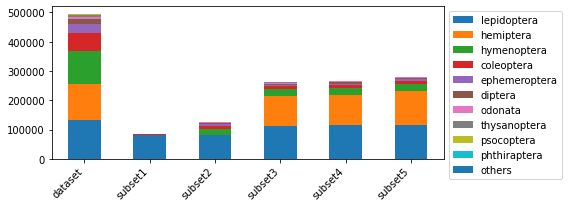

In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,3)

fig = plt.figure()
ax = order.transpose().plot.bar(stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.0))
plt.xticks(rotation=45, ha="right")
# plt.show()
plt.tight_layout()
plt.savefig('plots/order_balance.pdf')